# Classification problem for Student's Performance dataset

In [1]:
#importing all the necessary libraries
from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt

from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

This is 2nd part of data analysis of Student Perfomance dataset. 
First part with EDA  -  ['Linear Regression for Student's Grade dataset'](https://github.com/katerinaov/Machine-Learning-Supervised-Learning-/blob/master/Linear%20Regression%20on%20Student's%20Grades%20dataset.ipynb).

In [2]:
student_df = pd.read_csv('student-mat.csv', sep=';')
print(student_df.head())
print(student_df.info())
print(student_df.describe())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other ...   
3     GP   F   15       U     GT3       T     4     2   health  services ...   
4     GP   F   16       U     GT3       T     3     3    other     other ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33

As Regression models occured not the best fit for out dataset, let's try to solve this problem by 
4-level classification

In [3]:
def grades_label(grade):
    if grade >=0 and grade <6:
        return 1
    elif grade >= 6 and grade <11:
        return 2
    elif grade >=11 and grade < 16:
        return 3
    else:
        return 4


student_df['Grade'] = student_df['G3'].apply(grades_label)
student_df.drop('G3',1, inplace=True)


As was concluded in the first part of analysis, '0' outliers in 'G3' variable don't affect our model much
So we just leave it.

In [4]:
y = student_df['Grade']

X = student_df.drop('Grade', 1)
X = pd.get_dummies(X, drop_first=True)

Num Features: 5
Feature Ranking: [ 4 27 21  8 22 20 19 35 37 25 26 29 34 18  3  5 36  9 10  2 15 14 13 31
 11 23  6  1 32 33 16 17 24  1 30  1 12  7  1 28  1]


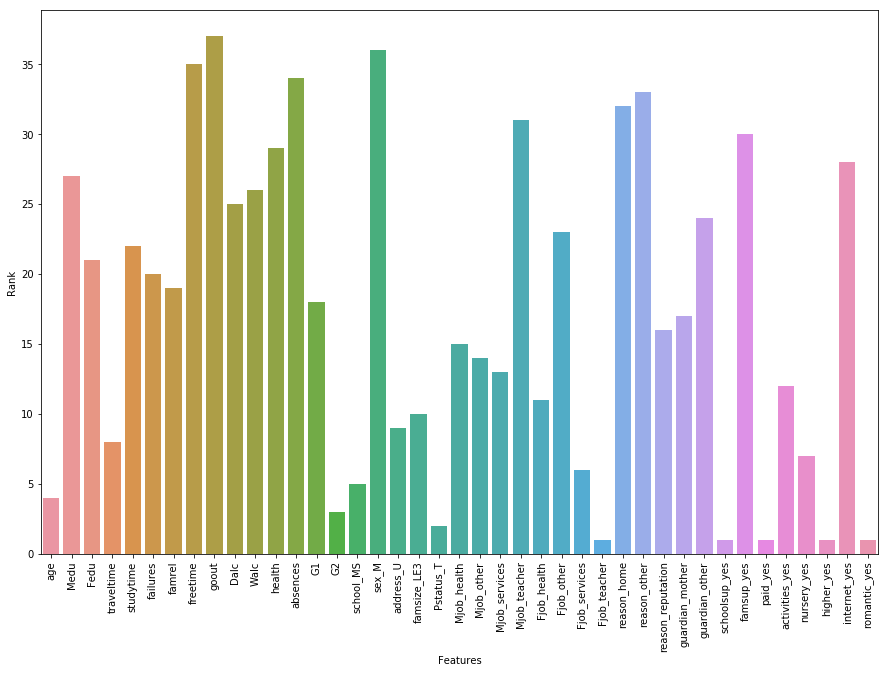

In [5]:
#Select important features for the model with Recursive feature elimination method
model = LogisticRegression()
rfe = RFE(model,5)
fit = rfe.fit(X, y)

print("Num Features: %s" % (fit.n_features_))
print("Feature Ranking: %s" % (fit.ranking_))

feature_scores = pd.DataFrame(X.columns)
feature_scores.columns  = ['Features']
feature_scores['Rank'] = pd.Series(fit.ranking_)

_ = plt.figure(figsize=(15,10))
_ = sns.barplot('Features', 'Rank', data=feature_scores)
_ = plt.xticks(rotation=90)
plt.show()

In [6]:
#Select 10 most important features according to RFE:
best_features = feature_scores.sort_values(by='Rank').iloc[:11,0]
print(best_features)
X = X[best_features]


40     romantic_yes
38       higher_yes
35         paid_yes
33    schoolsup_yes
27     Fjob_teacher
19        Pstatus_T
14               G2
0               age
15        school_MS
26    Fjob_services
37      nursery_yes
Name: Features, dtype: object


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
#Train Logistic Regression model
logreg = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



0.8151260504201681
[[ 8  8  0  0]
 [ 4 39  4  0]
 [ 0  1 40  1]
 [ 0  0  4 10]]
             precision    recall  f1-score   support

          1       0.67      0.50      0.57        16
          2       0.81      0.83      0.82        47
          3       0.83      0.95      0.89        42
          4       0.91      0.71      0.80        14

avg / total       0.81      0.82      0.81       119



In [9]:
#Train Kneighbor Classifier model,
#used GridSearcvCV to chose the best number of 'n_neighbors' parameter
params = {'n_neighbors': np.arange(1,10)}

knn = KNeighborsClassifier() 
knn_cv = GridSearchCV(knn, params, cv=5)
knn_cv.fit(X_train, y_train)
print(knn_cv.best_score_,knn_cv.best_params_ )

y_pred = knn_cv.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))



print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('RMSE', rmse)

0.8043478260869565 {'n_neighbors': 5}
0.8151260504201681
[[ 6 10  0  0]
 [ 4 41  2  0]
 [ 0  3 39  0]
 [ 0  0  3 11]]
             precision    recall  f1-score   support

          1       0.60      0.38      0.46        16
          2       0.76      0.87      0.81        47
          3       0.89      0.93      0.91        42
          4       1.00      0.79      0.88        14

avg / total       0.81      0.82      0.81       119

RMSE 0.42996970774675736


In [10]:
#Train Random Forest classifier model
rdn = RandomForestClassifier()
rdn.fit(X_train, y_train)

y_pred = rdn.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

print('RMSE', rmse)

0.7647058823529411
[[ 7  8  1  0]
 [ 7 37  3  0]
 [ 0  4 38  0]
 [ 0  0  5  9]]
             precision    recall  f1-score   support

          1       0.50      0.44      0.47        16
          2       0.76      0.79      0.77        47
          3       0.81      0.90      0.85        42
          4       1.00      0.64      0.78        14

avg / total       0.77      0.76      0.76       119

RMSE 0.5103961223213518


After 3 experiments with Logistic Regression, KneigborsClassifier and RandomForestClassifier, 
the second model is occured to work best with our data. Both accaracy of predictions and
root mean squared error are the best results.